In [22]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import shutil
import math
import csv
import os

In [7]:
# Condition constants
pho_l = 1.0  # Left boundary density
u_l = 0  # Left boundary gas velocity (along x)
p_l = 1.0  # Left boundary pressure

pho_r = 0.125  # Right boundary density
u_r = 0  # Right boundary gas velocity (along x)
p_r = 0.1  # Right boundary pressure

# Main part of the program
X = 1.0  # Coordinate boundary [meters]
T = 0.25  # Time boundary [seconds]

nx = 1000  # Number of steps on dimension coordinate
gamma = 1.4  # Polytropic index
cu = 0.99  # Courant number

dx = X / nx  # Coordinate step

In [8]:
# Condition functions
def left_boundary_condition(t):
    return [pho_l, pho_l * u_l, p_l / (gamma - 1) + 0.5 * pho_l * u_l**2]

def right_boundary_condition(t):
    return [pho_r, pho_r * u_r, p_r / (gamma - 1) + 0.5 * pho_r * u_r**2]

def initial_condition(i):
    if (i - 1) * dx < 0.5:
        return left_boundary_condition(0)
    else:
        return right_boundary_condition(0)

In [29]:
# Calculating functions
def eigenvalue(q):
    rho = q[0]
    u = q[1] / q[0]
    etot = q[2]
    eint = etot - 0.5 * rho * u**2
    p = eint * (gamma - 1)
    c = np.sqrt(gamma * p / rho)
    return [u - c, u, u + c]

def f(q):
    rho = q[0]
    u = q[1] / q[0]
    etot = q[2]
    eint = etot - 0.5 * rho * u**2
    p = eint * (gamma - 1)
    return np.array([q[1], rho * u**2 + p, (etot + p) * u])

def hll(q, dt):
    leigenvalues = eigenvalue(q[:, 0])
    reigenvalues = eigenvalue(q[:, 1])
    S_l = np.min(np.concatenate((leigenvalues, reigenvalues)))
    S_r = np.max(np.concatenate((leigenvalues, reigenvalues)))

    if S_r < 0:
        return f(q[:, 1])
    elif S_l > 0:
        return f(q[:, 0])
    else:
        qhll = (f(q[:, 0]) - f(q[:, 1]) + q[:, 1] * S_r - q[:, 0] * S_l) / (S_r - S_l)
        fhll = f(q[:, 1]) + S_r * (qhll - q[:, 1])
        return fhll

def calculate_cell(q, f_function, dt):
    return q[:, 1] - dt / dx * (f_function(q[:, 1:3], dt) - f_function(q[:, 0:2], dt))

In [30]:
csv_rho = open("output/rho.csv", "w", newline="")
csv_u = open("output/u.csv", "w", newline="")
csv_etot = open("output/etot.csv", "w", newline="")
csv_p = open("output/p.csv", "w", newline="")

writer_rho = csv.writer(csv_rho)
writer_u = csv.writer(csv_u)
writer_etot = csv.writer(csv_etot)
writer_p = csv.writer(csv_p)

headers = ["time"] + [f"x_{i}" for i in range(nx)]

writer_rho.writerow(headers)
writer_u.writerow(headers)
writer_etot.writerow(headers)
writer_p.writerow(headers)

# Creating a 2-dimension calculation field
Q0 = np.empty((3, nx))

for i in range(nx):
    Q0[:, i] = initial_condition(i)

# Main simulation loop
t = 0
while t < T:
    row_rho = np.array(Q0[0, :])
    row_u = np.array(Q0[1, :]) / row_rho
    row_etot = np.array(Q0[2, :])
    row_p = ((np.array(Q0[2, :]) - 0.5 * np.array(Q0[1, :])**2 / np.array(Q0[0, :])) * (gamma - 1))

    writer_rho.writerow(np.insert(row_rho, 0, t))
    writer_u.writerow(np.insert(row_u, 0, t))
    writer_etot.writerow(np.insert(row_etot, 0, t))
    writer_p.writerow(np.insert(row_p, 0, t))

    # Finding the time step
    lambda_val = float(np.abs(Q0[1, 0] / Q0[0, 0]))
    for i in range(nx):
        eigenvalues = eigenvalue(Q0[:, i])
        lambda_val = float(np.maximum(np.max(np.abs(eigenvalues)), lambda_val))

    dt = cu * dx / lambda_val

    t += dt

    # Creating the next time layer
    Q1 = np.empty_like(Q0)
    Q1[:, 0] = left_boundary_condition(t)
    Q1[:, -1] = right_boundary_condition(t)
    for i in range(1, nx - 1):
        Q1[:, i] = calculate_cell(Q0[:, i-1:i+2], hll, dt)

    Q0 = np.copy(Q1)

csv_rho.close()
csv_u.close()
csv_etot.close()
csv_p.close()

In [31]:
shutil.rmtree(output_dir)

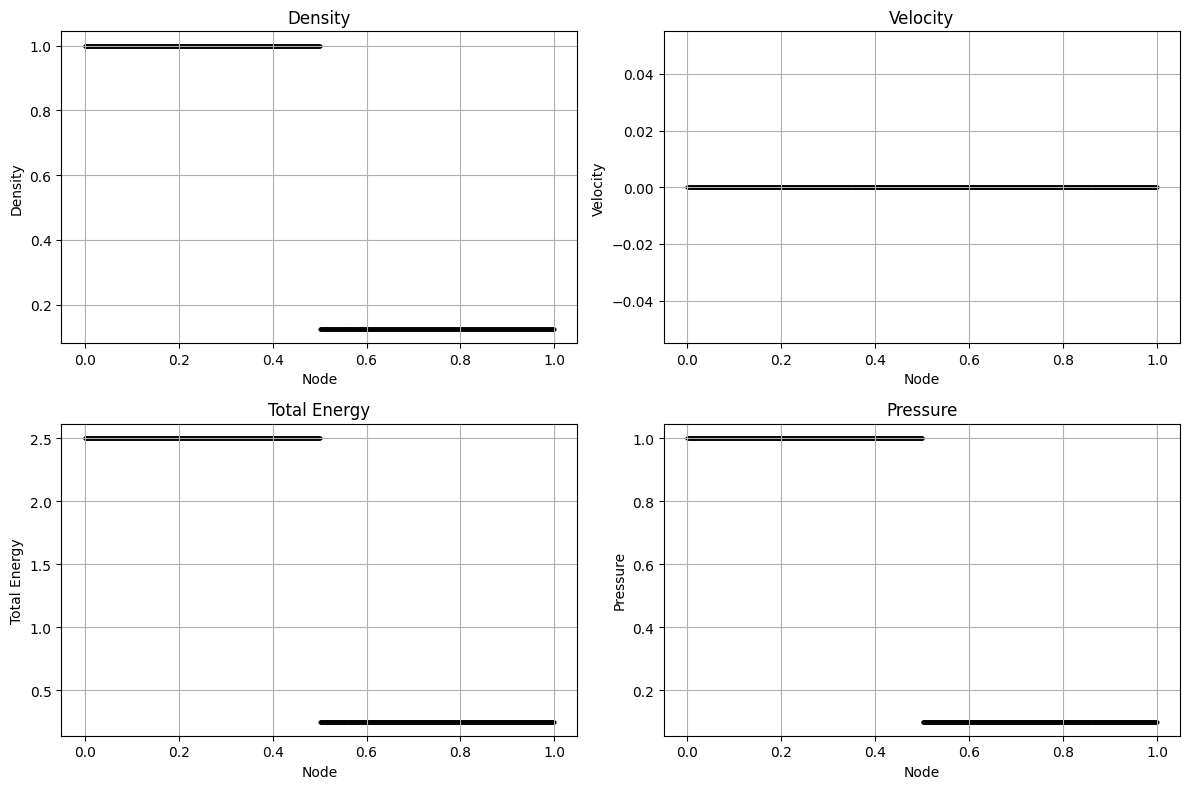

In [32]:
# Generate x
x = [dx * i for i in range(nx)]

# Load data from CSV file
def load_data(file_path):
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)
        data = np.array([row for row in reader], dtype=float)
    
    return headers, data

# Make directory for output
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# Load data
selected_file_path = "output/rho.csv"
headers_time, data_time = load_data(selected_file_path)
headers_rho, data_rho = load_data(selected_file_path)

selected_file_path = "output/u.csv"
headers_u, data_u = load_data(selected_file_path)

selected_file_path = "output/etot.csv"
headers_etot, data_etot = load_data(selected_file_path)

selected_file_path = "output/p.csv"
headers_p, data_p = load_data(selected_file_path)

# Создание GIF-анимации
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterval for plotting
update_interval = 10

def update(frame):
    axs[0, 0].clear()
    axs[0, 1].clear()
    axs[1, 0].clear()
    axs[1, 1].clear()

    selected_time = data_time[frame, 0]

    axs[0, 0].scatter(x, data_rho[frame, 1:], c='black', marker='o', s=4)
    axs[0, 0].set_title('Density')
    axs[0, 0].set_xlabel('Node')
    axs[0, 0].set_ylabel('Density')
    axs[0, 0].grid()

    axs[0, 1].scatter(x, data_u[frame, 1:], c='black', marker='o', s=4)
    axs[0, 1].set_title('Velocity')
    axs[0, 1].set_xlabel('Node')
    axs[0, 1].set_ylabel('Velocity')
    axs[0, 1].grid()

    axs[1, 0].scatter(x, data_etot[frame, 1:], c='black', marker='o', s=4)
    axs[1, 0].set_title('Total Energy')
    axs[1, 0].set_xlabel('Node')
    axs[1, 0].set_ylabel('Total Energy')
    axs[1, 0].grid()

    axs[1, 1].scatter(x, data_p[frame, 1:], c='black', marker='o', s=4)
    axs[1, 1].set_title('Pressure')
    axs[1, 1].set_xlabel('Node')
    axs[1, 1].set_ylabel('Pressure')
    axs[1, 1].grid()

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'frame_{frame:03d}.png'))

# Make animation
ani = animation.FuncAnimation(fig, update, frames=len(data_time), repeat=False)

# Save GIF
ani.save('animation.gif', writer='pillow', fps=10)

# # Clean up output dir
# shutil.rmtree(output_dir)

При -∞<x<∞ находится совершенный газ при давлении 1атм с плотностью 1 кг/м3. γ=1.4.
На интервале –Le/2<x<Le/2 к газу добавляется кинетическая энергия 1МДж/м2.
Определить при каком Le размер области, в которой давление газа хотя бы в один момент времени превышало Pmax=1.5 атм, будет максимальным. 
Найти этот размер.